![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1315]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from collections import Counter

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import re
from datetime import datetime, timedelta
import time

# Any results you write to the current directory are saved as output.

In [1316]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [1317]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [1318]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [1319]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [1320]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [1321]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [1322]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [1323]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [1324]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [1325]:
# обогатим наш датасет внешними данными: 
# 1. population - население города, в котором находится ресторан
# 2. capital -  метка - является ли город столицей
# 3. touristical range - туристический рейтинг, баллами отмечены города с наибольшим туристическим потоком, чем более
# туристически привлекательный город - тем больше баллов 
# 4. mean salary - средняя заработная плата в стране (брутто) в долларах США

df2 = pd.read_excel('city1.xlsx')
data = pd.merge(data, df2, how = 'inner', on = 'City')

In [1326]:
# добавляем признак с площаью города

data['City square'] = data['City'].map({'London': 1572, 'Paris': 105.4, 'Madrid':604.3, 'Barcelona':101.9,
                                       'Berlin':891.8, 'Milan':181.8, 'Rome':1285, 'Prague':496,
                                       'Lisbon':100, 'Vienna':414.6, 'Amsterdam':219.3, 'Brussels':32.61,
                                       'Hamburg':755.2, 'Munich':310.4, 'Lyon':47.87, 'Stockholm':188,
                                       'Budapest':525.2, 'Warsaw':517.2, 'Dublin':115, 'Copenhagen':88.25,
                                       'Athens':2929, 'Edinburgh':264, 'Zurich':87.88, 'Oporto':41.42,
                                       'Geneva':15.93, 'Krakow':327, 'Oslo':454, 'Helsinki':213.8,
                                       'Bratislava':367.6, 'Luxembourg':51.46, 'Ljubljana':163.8}) 

In [1327]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Population         50000 non-null  int64  
 12  capital            50000 non-null  int64  
 13  touristical range  50000 non-null  int64  
 14  mean salary        50000 non-null  int64  
 15  City square        50000 non-null  float64
dtypes: float64(4), int64(5

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [1328]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Population,capital,touristical range,mean salary,City square
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2257981,1,12,3332,105.4
1,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0,2257981,1,12,3332,105.4
2,id_15,Paris,['French'],12899.0,$,39.0,"[['Very nice food and staff', 'Lovely service ...",/Restaurant_Review-g187147-d7605609-Reviews-Le...,d7605609,0,0.0,2257981,1,12,3332,105.4
3,id_31,Paris,NaN,3156.0,NaN,19.0,"[['Very good food'], ['09/24/2017']]",/Restaurant_Review-g187147-d11953078-Reviews-B...,d11953078,0,0.0,2257981,1,12,3332,105.4
4,id_34,Paris,['French'],476.0,$$ - $$$,136.0,"[['Worthy of a trip out of the city centre!', ...",/Restaurant_Review-g187147-d9597870-Reviews-La...,d9597870,0,0.0,2257981,1,12,3332,105.4


In [1329]:
# введем еще один признак - отношение численности населения к Ranking

data['Pop_per_ranking'] = data['Population']/data['Ranking']
data['Pop_per_ranking']

0         174.186608
1         443.349892
2         175.050857
3         715.456591
4        4743.657563
            ...     
49995    1453.162304
49996     797.568966
49997     645.474419
49998     818.743363
49999    1380.865672
Name: Pop_per_ranking, Length: 50000, dtype: float64

In [1330]:
# введем еще один признак - отношение численности населения к Ranking

data['Number of Reviews'] = data['Number of Reviews'].fillna(1)

data['Rew_per_ranking'] = data['Number of Reviews']/data['Ranking']
data['Rew_per_ranking']


0        0.000309
1        0.004712
2        0.003023
3        0.006020
4        0.285714
           ...   
49995    0.314136
49996    0.028736
49997    0.020930
49998    0.026549
49999    0.049751
Name: Rew_per_ranking, Length: 50000, dtype: float64

In [1331]:
data.Reviews[1]

"[['Lunch Break', 'Good to Quick Bite'], ['09/07/2017', '09/02/2017']]"

In [1332]:
len(pd.DataFrame(data['City'].value_counts()))

31

In [1333]:
pd.DataFrame(data['ID_TA'].value_counts()).head(50)

# есть 20 ресторанов, Id которых на ресурсе Trip_Advisor повторяются

,ID_TA
d7337366,2
d697406,2
d7809594,2
d12488993,2
d3396817,2
d10047799,2
d4600226,2
d987900,2
d1028622,2
d7827387,2


In [1334]:
data.Rating.median()

4.0

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [1335]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [1336]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [1337]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [1338]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Population                    31
capital                        2
touristical range             14
mean salary                   22
City square                   31
Pop_per_ranking            49998
Rew_per_ranking            43482
Number_of_Reviews_isNAN        1
dtype: int64

In [1339]:
# найдем самое полупярное значение кухни, из результатов видим, что это Vegetarian Friendly кухня.


data['Cuisine Style'] = data['Cuisine Style'].str.replace('[', '')
data['Cuisine Style'] = data['Cuisine Style'].str.replace(']', '')
pd.Series(data['Cuisine Style'].str.cat(sep = ',').split(',')).replace('[', '').value_counts(ascending = False)

 'Vegetarian Friendly'    13630
 'European'                9872
'Italian'                  6887
 'Vegan Options'           5667
 'Mediterranean'           5201
                          ...  
'Romanian'                    1
'Ethiopian'                   1
'Uzbek'                       1
 'Latvian'                    1
 'Salvadoran'                 1
Length: 232, dtype: int64

In [1340]:
# изначально предполагала, что заменю пустые значения на самое частое значение, но думаю, что лучше будет 
# заменить на "кухня не определена"

data['Cuisine Style'] = data['Cuisine Style'].fillna('Cuisine is Not defined')
pd.Series(data['Cuisine Style'].str.cat(sep = ',').split(',')).replace('[', '').value_counts(ascending = False)

 'Vegetarian Friendly'    13630
Cuisine is Not defined    11590
 'European'                9872
'Italian'                  6887
 'Vegan Options'           5667
                          ...  
 'Burmese'                    1
'Central American'            1
'Balti'                       1
'Uzbek'                       1
 'Salvadoran'                 1
Length: 233, dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [1341]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns = ['City'], dummy_na=True)

In [1342]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"'Bar', 'Pub'",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_5,"'French', 'Cafe', 'Fast Food'",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,id_15,'French',12899.0,$,39.0,"[['Very nice food and staff', 'Lovely service ...",/Restaurant_Review-g187147-d7605609-Reviews-Le...,d7605609,0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,id_31,Cuisine is Not defined,3156.0,NaN,19.0,"[['Very good food'], ['09/24/2017']]",/Restaurant_Review-g187147-d11953078-Reviews-B...,d11953078,0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,id_34,'French',476.0,$$ - $$$,136.0,"[['Worthy of a trip out of the city centre!', ...",/Restaurant_Review-g187147-d9597870-Reviews-La...,d9597870,0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [1343]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
15109,id_6191,"'European', 'Portuguese'",2933.0,NaN,1.0,"[['Excellent Meal at a reasonable price'], ['0...",/Restaurant_Review-g189158-d12790648-Reviews-R...,d12790648,0,0.0,...,0,0,0,0,0,0,0,0,0,0
33061,id_5676,Cuisine is Not defined,5677.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187497-d11777366-Reviews-R...,d11777366,1,4.0,...,0,0,0,0,0,0,0,0,0,0
38344,id_7410,'American',7416.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187514-d10042189-Reviews-F...,d10042189,1,3.5,...,0,0,0,0,0,0,0,0,0,0
45790,id_762,"'Polish', 'European', 'Central European', 'Eas...",763.0,$$ - $$$,77.0,"[['Great food', 'Overpriced cantine'], ['07/29...",/Restaurant_Review-g274856-d3929171-Reviews-Re...,d3929171,1,4.0,...,0,0,0,0,0,0,0,1,0,0
32554,id_1625,"'Fast Food', 'Spanish'",1626.0,$,275.0,"[['The really cheap restaurant', 'Sunday is yo...",/Restaurant_Review-g187497-d4409936-Reviews-Ce...,d4409936,1,4.0,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [1344]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [1345]:
# Ваша обработка 'Price Range'
price_dict = {'$':1, '$$ - $$$':2, '$$$$':3}
data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)



In [1346]:
# найдем значение Price Range, которое встречается чаще всего, чтобы в дальнейшем заполнить пропущенные значения
data[['Price Range']].median()

Price Range    2.0
dtype: float64

In [1347]:
# найдем значение Price Range, которое встречается чаще всего, чтобы в дальнейшем заполнить пропущенные значения
data['Price Range'] = data['Price Range'].fillna('2')

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [1348]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

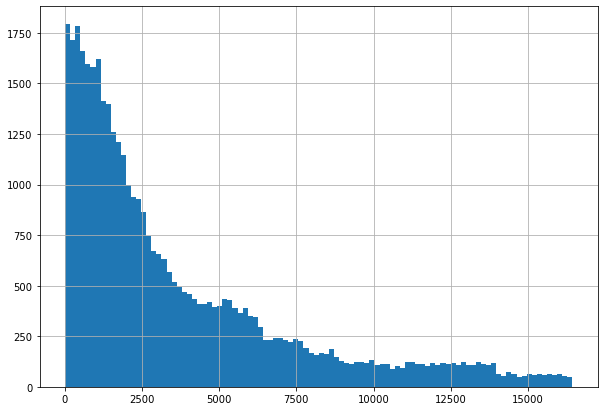

In [1349]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

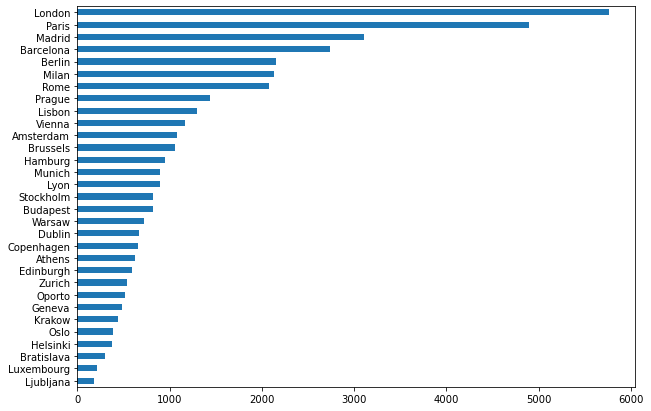

In [1350]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

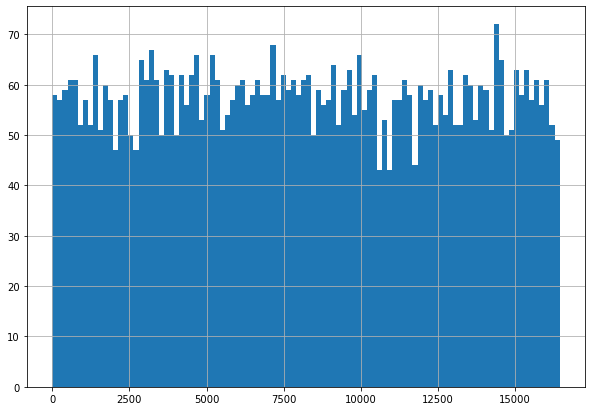

In [1351]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

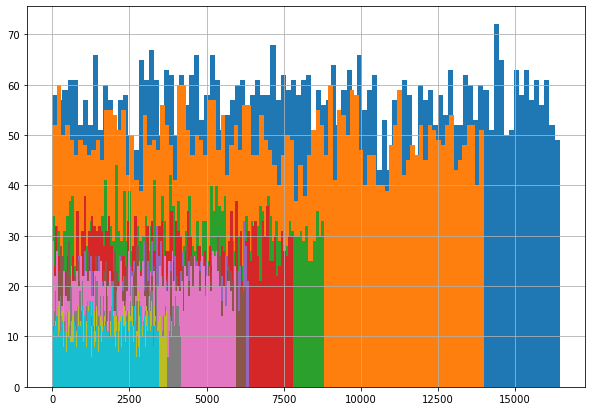

In [1352]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

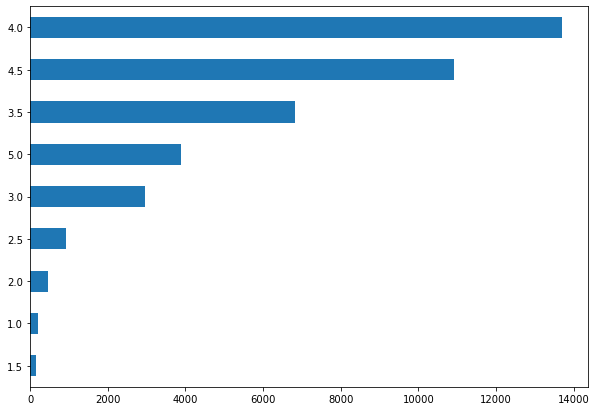

In [1353]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

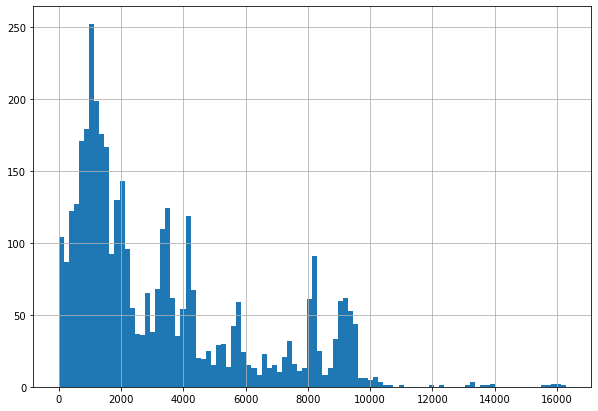

In [1354]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

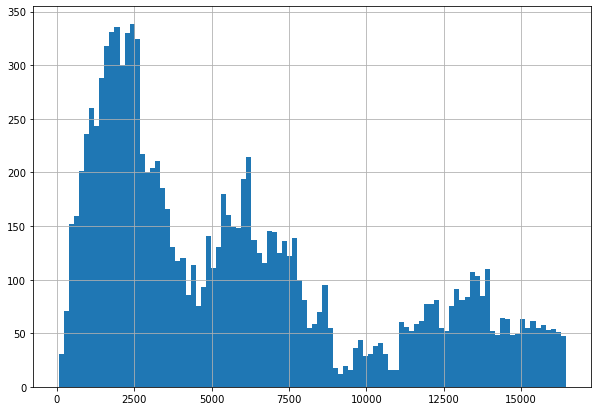

In [1355]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

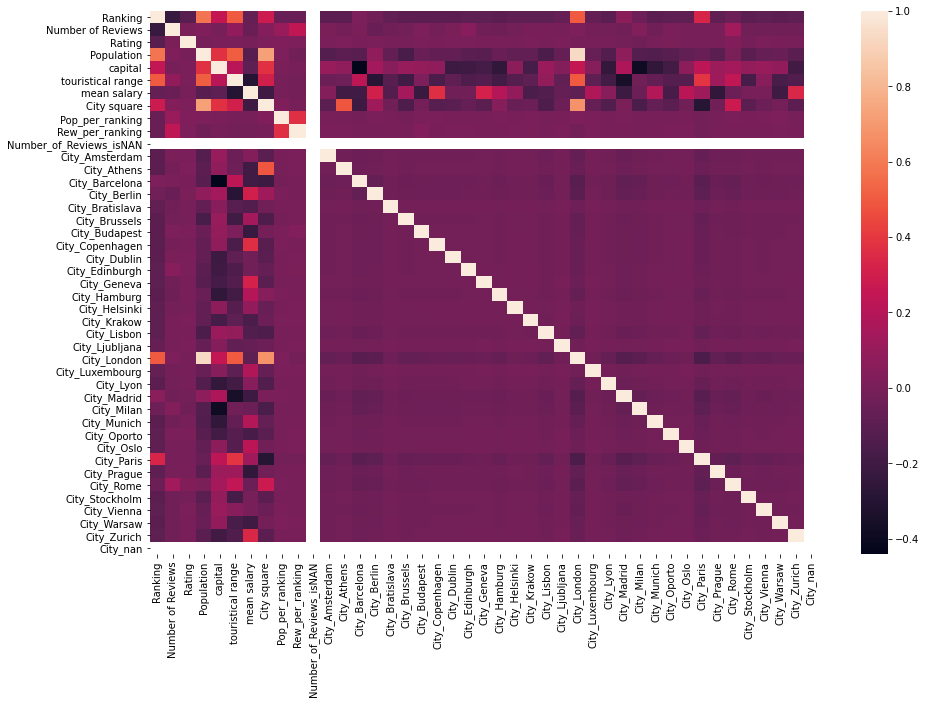

In [1356]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [1357]:
data.drop(['Restaurant_id','ID_TA','URL_TA', 'Reviews', 'Cuisine Style'], axis = 1, inplace=True)
data['Number of Reviews'].fillna(0, inplace=True)
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [1358]:
data

,Ranking,Number of Reviews,sample,Rating,Population,capital,touristical range,mean salary,City square,Pop_per_ranking,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,12963.0,4.0,0,0.0,2257981,1,12,3332,105.4,174.186608,...,0,0,1,0,0,0,0,0,0,0
1,5093.0,24.0,0,0.0,2257981,1,12,3332,105.4,443.349892,...,0,0,1,0,0,0,0,0,0,0
2,12899.0,39.0,0,0.0,2257981,1,12,3332,105.4,175.050857,...,0,0,1,0,0,0,0,0,0,0
3,3156.0,19.0,0,0.0,2257981,1,12,3332,105.4,715.456591,...,0,0,1,0,0,0,0,0,0,0
4,476.0,136.0,0,0.0,2257981,1,12,3332,105.4,4743.657563,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,191.0,60.0,1,4.0,277554,1,0,1914,163.8,1453.162304,...,0,0,0,0,0,0,0,0,0,0
49996,348.0,10.0,1,4.0,277554,1,0,1914,163.8,797.568966,...,0,0,0,0,0,0,0,0,0,0
49997,430.0,9.0,1,3.5,277554,1,0,1914,163.8,645.474419,...,0,0,0,0,0,0,0,0,0,0
49998,339.0,9.0,1,4.0,277554,1,0,1914,163.8,818.743363,...,0,0,0,0,0,0,0,0,0,0


>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [1359]:
data.sample(10)

,Ranking,Number of Reviews,sample,Rating,Population,capital,touristical range,mean salary,City square,Pop_per_ranking,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
5701,800.0,821.0,1,4.0,2257981,1,12,3332,105.4,2822.476250,...,0,0,1,0,0,0,0,0,0,0
12414,9980.0,5.0,1,4.5,8416999,1,13,2703,1572.0,843.386673,...,0,0,0,0,0,0,0,0,0,0
27542,959.0,22.0,1,4.5,1290211,1,10,1454,496.0,1345.371220,...,0,0,0,1,0,0,0,0,0,0
5199,12020.0,20.0,1,3.0,2257981,1,12,3332,105.4,187.851997,...,0,0,1,0,0,0,0,0,0,0
12084,7244.0,14.0,1,4.5,8416999,1,13,2703,1572.0,1161.926974,...,0,0,0,0,0,0,0,0,0,0
27377,2863.0,11.0,1,3.5,1290211,1,10,1454,496.0,450.650017,...,0,0,0,1,0,0,0,0,0,0
18619,5201.0,6.0,0,0.0,2761477,1,12,2726,1285.0,530.951163,...,0,0,0,0,1,0,0,0,0,0
45671,1245.0,11.0,1,3.5,1716855,1,0,1253,517.2,1379.000000,...,0,0,0,0,0,0,0,1,0,0
25636,979.0,42.0,1,4.0,1787220,0,0,4392,755.2,1825.556691,...,0,0,0,0,0,0,0,0,0,0
18518,1989.0,43.0,1,3.5,847073,1,0,2893,188.0,425.878834,...,0,0,0,0,0,1,0,0,0,0


In [1360]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  50000 non-null  float64
 1   Number of Reviews        50000 non-null  float64
 2   sample                   50000 non-null  int64  
 3   Rating                   50000 non-null  float64
 4   Population               50000 non-null  int64  
 5   capital                  50000 non-null  int64  
 6   touristical range        50000 non-null  int64  
 7   mean salary              50000 non-null  int64  
 8   City square              50000 non-null  float64
 9   Pop_per_ranking          50000 non-null  float64
 10  Rew_per_ranking          50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
 12  City_Amsterdam           50000 non-null  uint8  
 13  City_Athens              50000 non-null  uint8  
 14  City_Barcelona        

In [1361]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [1362]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1363]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 43), (40000, 43), (40000, 42), (32000, 42), (8000, 42))

# Model 
Сам ML

In [1364]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [1365]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1366]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1367]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21018062499999998


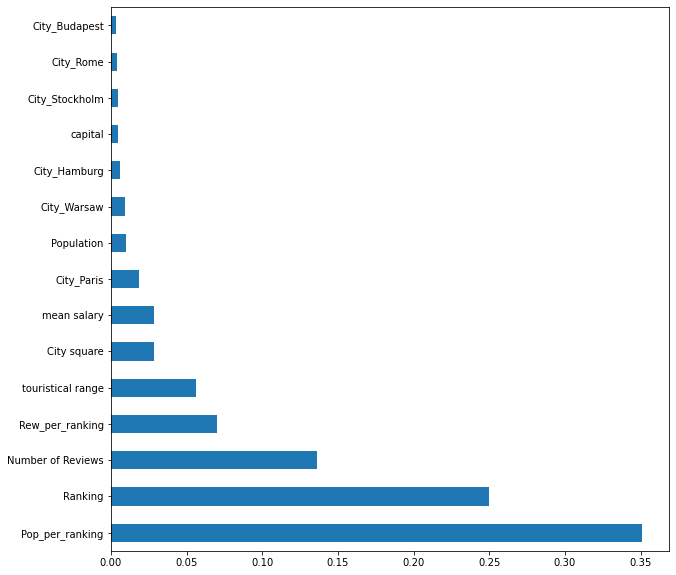

In [1368]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [1369]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Population,capital,touristical range,mean salary,City square,Pop_per_ranking,Rew_per_ranking,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
8142,7510.0,27.0,0.0,8416999,1,13,2703,1572.00,1120.772170,0.003595,...,0,0,0,0,0,0,0,0,0,0
33900,2155.0,34.0,0.0,144784,1,0,3930,32.61,67.185151,0.015777,...,0,0,0,0,0,0,0,0,0,0
16680,114.0,230.0,0.0,1721556,1,7,1187,525.20,15101.368421,2.017544,...,0,0,0,0,0,0,0,0,0,0
7834,15585.0,39.0,0.0,8416999,1,13,2703,1572.00,540.070517,0.002502,...,0,0,0,0,0,0,0,0,0,0
44639,1269.0,9.0,0.0,655780,1,5,1203,2929.00,516.769110,0.007092,...,0,0,0,0,0,0,0,0,0,0
33868,2393.0,4.0,0.0,144784,1,0,3930,32.61,60.503134,0.001672,...,0,0,0,0,0,0,0,0,0,0
40881,1187.0,25.0,0.0,3479240,1,0,4392,891.80,2931.120472,0.021061,...,0,0,0,0,0,0,0,0,0,0
33803,2851.0,48.0,0.0,144784,1,0,3930,32.61,50.783585,0.016836,...,0,0,0,0,0,0,0,0,0,0
1203,9005.0,9.0,0.0,2257981,1,12,3332,105.40,250.747474,0.000999,...,0,0,1,0,0,0,0,0,0,0
18810,3947.0,33.0,0.0,2761477,1,12,2726,1285.00,699.639473,0.008361,...,0,0,0,0,1,0,0,0,0,0


In [1370]:
test_data = test_data.drop(['Rating'], axis=1)

In [1371]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [1372]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1373]:
predict_submission

array([3.085, 4.165, 3.015, ..., 4.19 , 4.28 , 4.375])

In [1374]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.085
1,id_1,4.165
2,id_2,3.015
3,id_3,4.765
4,id_4,4.520
5,id_5,3.755
6,id_6,3.765
7,id_7,2.970
8,id_8,3.295
9,id_9,4.045


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
